In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import joblib # Para guardar el modelo

In [2]:
plt.style.use('seaborn-v0_8-whitegrid') # Estilo
plt.rcParams['figure.figsize'] = (14, 10) # Tamaño

In [3]:
# 1. CARGA Y LIMPIEZA DE DATOS
df_main = pd.read_csv('checking_account_main.csv')
df_sec = pd.read_csv('checking_account_secondary.csv')
df_cc = pd.read_csv('credit_card_account.csv')

# Función auxiliar para convertir fechas
def preprocess_dates(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

df_main = preprocess_dates(df_main)
df_sec = preprocess_dates(df_sec)
df_cc = preprocess_dates(df_cc)

# --- Agrupación Semanal ---
# Ingresos: Solo tomamos 'Sales Revenue'
daily_sales = df_main[df_main['category'] == 'Sales Revenue'].groupby('date')['amount'].sum().reset_index()
daily_sales.columns = ['date', 'sales']

# Gastos: Sumamos todo lo que sea salida de dinero (Operating, Payroll, Credit Card)
# Excluimos 'Transfer' porque es movimiento interno de dinero, no gasto real.
exp_main = df_main[(df_main['type'] == 'Debit') & (df_main['category'] != 'Transfer')]
exp_sec = df_sec[df_sec['category'] == 'Payroll']
exp_cc = df_cc[df_cc['type'] == 'Debit']

all_expenses = pd.concat([exp_main, exp_sec, exp_cc])
daily_expenses = all_expenses.groupby('date')['amount'].sum().reset_index()
daily_expenses.columns = ['date', 'expenses']

# Merge final y resampling semanal (W-MON = Semanas que inician en Lunes)
df_combined = pd.merge(daily_sales, daily_expenses, on='date', how='outer').fillna(0)
df_combined = df_combined.sort_values('date')
df_weekly = df_combined.set_index('date').resample('W-MON').sum().reset_index()

In [4]:
#Creamos variables del pasado para predecir el futuro
lags = [1, 2, 4] # 1 semana, 2 semanas, 1 mes atrás
for i in lags:
    df_weekly[f'sales_lag_{i}'] = df_weekly['sales'].shift(i)
    df_weekly[f'expenses_lag_{i}'] = df_weekly['expenses'].shift(i)

df_model = df_weekly.dropna() # Limpiamos los NaNs generados por el shift

In [5]:
# Definimos X (Features) y Y (Targets)
features = [col for col in df_model.columns if 'lag' in col]
X = df_model[features]
y_sales = df_model['sales']
y_expenses = df_model['expenses']

In [6]:
# Split temporal (80% train, 20% test) - NO aleatorio porque es serie de tiempo
split = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_sales_train, y_sales_test = y_sales.iloc[:split], y_sales.iloc[split:]
y_exp_train, y_exp_test = y_expenses.iloc[:split], y_expenses.iloc[split:]

In [7]:
# Entrenamiento
model_sales = LinearRegression().fit(X_train, y_sales_train)
model_exp = LinearRegression().fit(X_train, y_exp_train)

In [8]:
y_exp_pred = model_exp.predict(X_test)

df_results = pd.DataFrame({
    'date': df_model.iloc[split:]['date'],
    'actual_expenses': y_exp_test,
    'predicted_expenses': y_exp_pred
}).set_index('date')

In [9]:
print('Coeficientes del Modelo de Gastos:')
for feature, coef in zip(X_train.columns, model_exp.coef_):
    print(f'{feature}: {coef:.4f}')
print(f'Intercepto: {model_exp.intercept_:.4f}')

Coeficientes del Modelo de Gastos:
sales_lag_1: 0.5187
expenses_lag_1: -0.2247
sales_lag_2: -0.6339
expenses_lag_2: -0.2313
sales_lag_4: 0.0658
expenses_lag_4: 0.4294
Intercepto: 1999.9386


In [10]:
mae = mean_absolute_error(y_exp_test, y_exp_pred)
r2 = r2_score(y_exp_test, y_exp_pred)

print(f'Error Absoluto Medio (MAE) para Gastos: {mae:.2f}')
print(f'Coeficiente de Determinación (R²) para Gastos: {r2:.2f}')

Error Absoluto Medio (MAE) para Gastos: 1223.11
Coeficiente de Determinación (R²) para Gastos: 0.15


In [11]:
y_sales_pred = model_sales.predict(X_test)
mae_sales = mean_absolute_error(y_sales_test, y_sales_pred)
r2_sales = r2_score(y_sales_test, y_sales_pred)

print(f'Error Absoluto Medio (MAE) para Ventas: {mae_sales:.2f}')
print(f'Coeficiente de Determinación (R²) para Ventas: {r2_sales:.2f}')

Error Absoluto Medio (MAE) para Ventas: 410.57
Coeficiente de Determinación (R²) para Ventas: -0.03


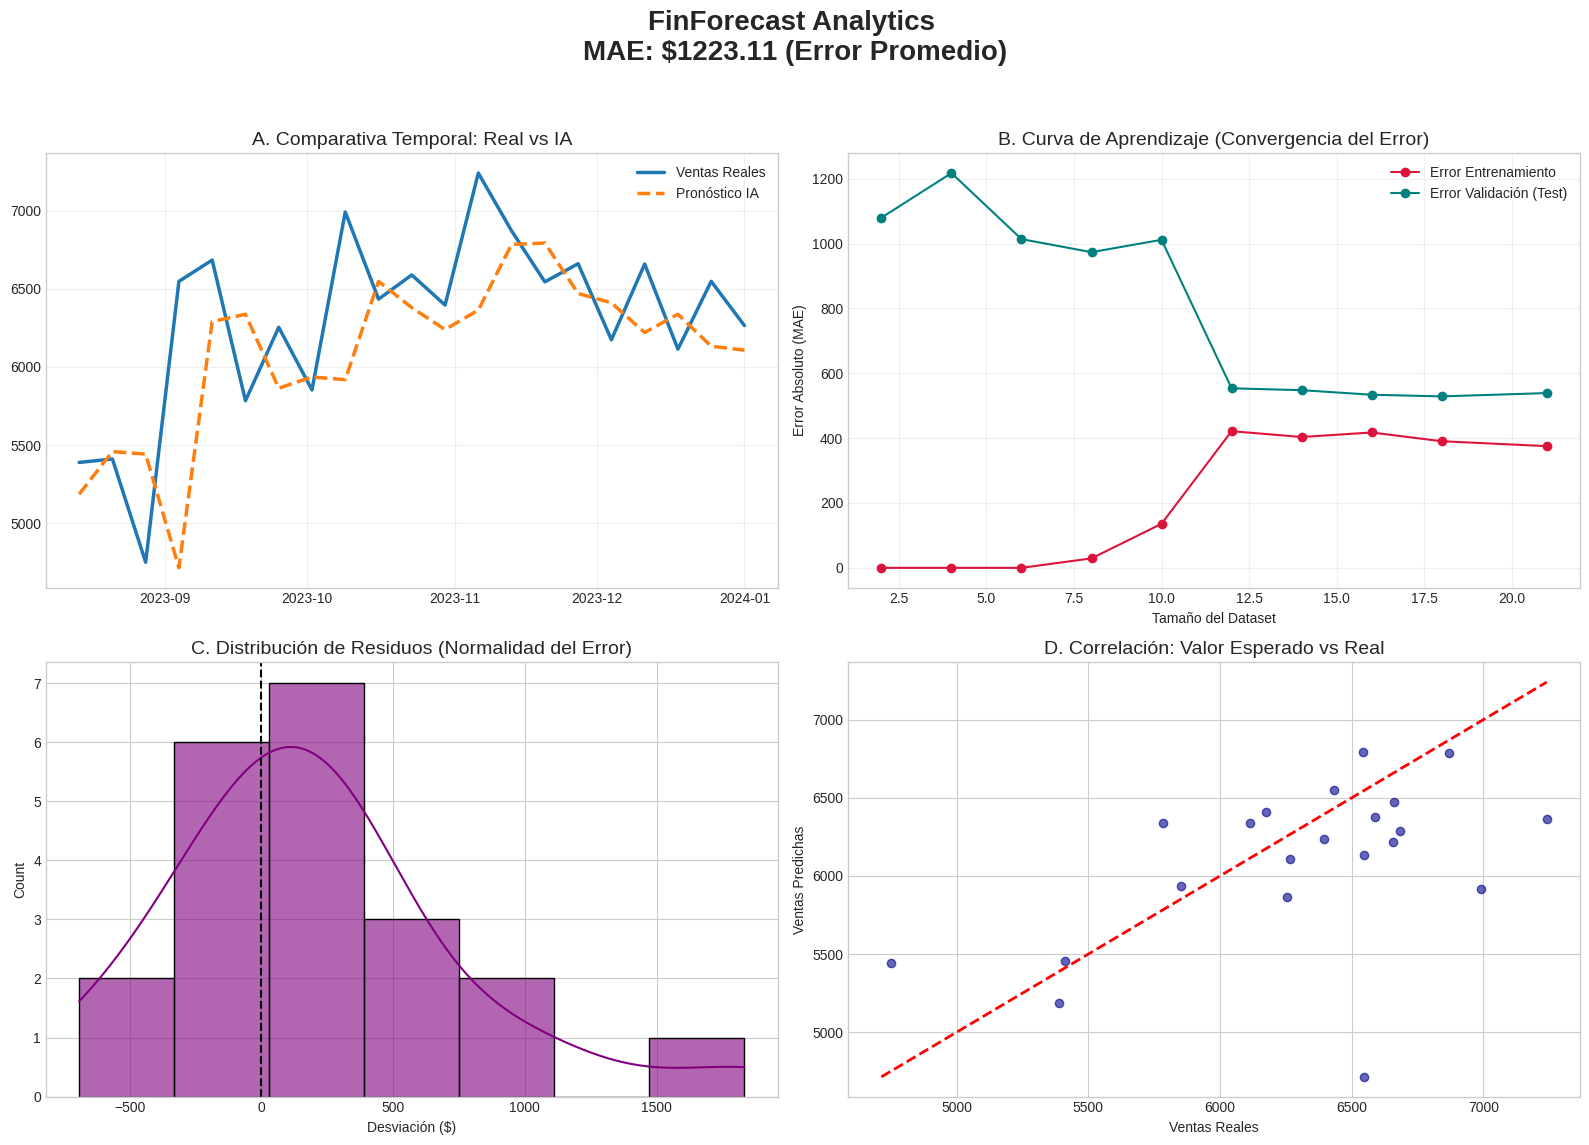

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'FinForecast Analytics \nMAE: ${mae:.2f} (Error Promedio)', fontsize=20, weight='bold')

# A: Serie de Tiempo (Real vs Predicho)
axs[0, 0].plot(df_model.iloc[split:]['date'], y_sales_test, label='Ventas Reales', color='#1f77b4', linewidth=2.5)
axs[0, 0].plot(df_model.iloc[split:]['date'], y_sales_pred, label='Pronóstico IA', color='#ff7f0e', linestyle='--', linewidth=2.5)
axs[0, 0].set_title('A. Comparativa Temporal: Real vs IA', fontsize=14)
axs[0, 0].legend()
axs[0, 0].grid(True, alpha=0.3)

# B: Curva de Aprendizaje (Simula "Loss Graph")
# Muestra si el modelo mejora al tener más datos
train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(), X, y_sales, cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1, 1.0, 10))

# Convertimos score negativo a error positivo
mean_train_error = -train_scores.mean(axis=1)
mean_test_error = -test_scores.mean(axis=1)

axs[0, 1].plot(train_sizes, mean_train_error, 'o-', color='crimson', label='Error Entrenamiento')
axs[0, 1].plot(train_sizes, mean_test_error, 'o-', color='teal', label='Error Validación (Test)')
axs[0, 1].set_title('B. Curva de Aprendizaje (Convergencia del Error)', fontsize=14)
axs[0, 1].set_xlabel('Tamaño del Dataset')
axs[0, 1].set_ylabel('Error Absoluto (MAE)')
axs[0, 1].legend()
axs[0, 1].grid(True, alpha=0.3)

# C: Distribución de Errores (Histograma de Residuos)
residuals = y_sales_test - y_sales_pred
sns.histplot(residuals, kde=True, ax=axs[1, 0], color='purple', alpha=0.6)
axs[1, 0].axvline(0, color='black', linestyle='--')
axs[1, 0].set_title('C. Distribución de Residuos (Normalidad del Error)', fontsize=14)
axs[1, 0].set_xlabel('Desviación ($)')

# D: Correlación
axs[1, 1].scatter(y_sales_test, y_sales_pred, alpha=0.6, color='darkblue')
max_val = max(y_sales_test.max(), y_sales_pred.max())
min_val = min(y_sales_test.min(), y_sales_pred.min())
axs[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2) # Línea ideal
axs[1, 1].set_title('D. Correlación: Valor Esperado vs Real', fontsize=14)
axs[1, 1].set_xlabel('Ventas Reales')
axs[1, 1].set_ylabel('Ventas Predichas')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [19]:
# Guardar modelos
joblib.dump(model_sales, 'modelo_ventas_pro.pkl')
joblib.dump(model_exp, 'modelo_gastos_pro.pkl')

['modelo_gastos_pro.pkl']